In [3]:
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage
from typing import Annotated, Sequence, TypedDict
import os
from dotenv import load_dotenv
from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage
import json
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableConfig

load_dotenv()

True

## Define state

In [4]:
class AgentState(TypedDict):
    """The state of the agent."""
    # Sequence[BaseMessage]: danh sách các message (vd: HumanMessage, AIMessage, ToolMessage])
    # add_messages: hàm để thêm message vào danh sách
    messages: Annotated[Sequence[BaseMessage], add_messages]
    number_of_steps: int

## Define tools

In [5]:
@tool
def triple(num: float) -> float:
    """
    :param num: a number to triple
    :return: the number tripled -> multiplied by 3
    """
    return 3 * float(num)


tools = [TavilySearch(max_results=1), triple]

system_prompt = SystemMessage(
    """
    You are a reasoning agent. Always think step-by-step.

    Use the following format:

    Thought: what you are thinking
    Action: the action to take, e.g. ‘search’, ‘calculate’
    Action Input: the input to the action
    Observation: the result of the action

    (Repeat Thought / Action / Observation if needed)

    Final Answer: your answer to the user

    Question: {input}
    """
)

model = ChatOpenAI(
    base_url="http://127.0.0.1:1234/v1",
    api_key="not-needed",  # LM Studio không yêu cầu API key
    temperature=0.7,
)

response2 = model.invoke("Xin chào, bạn khỏe không?")
print(response2.content)

Chào! Tôi là một mô hình ngôn ngữ, vì vậy tôi không có thể bị bệnh hay cảm thấy mệt mỏi như con người. Tôi luôn sẵn sàng giúp đỡ và trả lời các câu hỏi của bạn!


## Defining nodes and edges

In [6]:
tools_by_name = {tool.name: tool for tool in tools}

# Define our tool node
def tool_node(state: AgentState):
    outputs = []
    for tool_call in state["messages"][-1].tool_calls:
        tool_result = tools_by_name[tool_call["name"]].invoke(
            tool_call["args"])
        outputs.append(
            ToolMessage(
                content=json.dumps(tool_result),
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}


# Define the node that calls the model
def call_model(
    state: AgentState,
    config: RunnableConfig,
):
    response = model.invoke([system_prompt] + state["messages"], config)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

# Define the conditional edge that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"

## Build Graph

In [7]:
from langgraph.graph import StateGraph, END

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set start node : start -> agent
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools", 
        "end": END,      
    },
)

# We now add a normal edge from ‘tools‘ to ‘agent‘.
# This means that after ‘tools‘ is called, ‘agent‘ node is called next.
workflow.add_edge("tools", "agent")

# Now we can compile and visualize our graph
graph = workflow.compile()

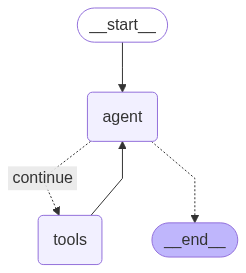

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass